<a href="https://colab.research.google.com/github/jackliu333/object_detection_using_tensorflow/blob/main/FoodBank_Training_Customised_Image_Detection_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Codes adapted from https://github.com/nicknochnack/TFODCourse/blob/main/2.%20Training%20and%20Detection.ipynb
# Images sampled from https://github.com/jackliu333/object_detection_using_tensorflow, with bounding boxes drawn manually for each object
# To run using Google Colab; switch runtime type to GPU for speedup
import numpy as np
import random
import tensorflow as tf

SEED = 123
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Configuration parameters

Including paths and training hyper-parameters

In [2]:
import os
print(f"Current OS: {os.name}") 

Current OS: posix


In [3]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 

# SSD has good tradeoff between speed and accuracy; can switch to other pretrained model
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'

# TF official script to encode training data to tf record format
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'

# Mapping dictionary between label and integer id
LABEL_MAP_NAME = 'label_map.pbtxt'

# Define a list of folder paths to be created (if needed) and used later
paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    # bounding box annotation
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'PROTOC_PATH':os.path.join('Tensorflow','protoc')
}

training_files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [4]:
# create folder paths if not exist
for p in paths.values():
    if not os.path.exists(p):
        !mkdir -p {p}

# Set up TF model training logistics

### Download TF model training utility scripts from TF model zoo

In [5]:
if not os.path.exists(os.path.join(paths['APIMODEL_PATH'], 'research', 'objection_detection')):
    !git clone https://github.com/tensorflow/models {paths['APIMODEL_PATH']}

Cloning into 'Tensorflow/models'...
remote: Enumerating objects: 77202, done.
remote: Counting objects: 100% (496/496), done.
remote: Compressing objects: 100% (272/272), done.
remote: Total 77202 (delta 232), reused 443 (delta 214), pack-reused 76706
Receiving objects: 100% (77202/77202), 593.33 MiB | 20.87 MiB/s, done.
Resolving deltas: 100% (54743/54743), done.


### Install TF object detection library

May hit some error during installation, can be ignored, as long as it returns "OK" in the last line.

In [6]:
if os.name=='posix':  
    !apt-get install protobuf-compiler
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install . 


Reading package lists... Done
Building dependency tree       
Reading state information... Done
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/Tensorflow/models/research
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 10.9 MB 9.1 MB/s 
     |███████████████████████████████

In [7]:
# Verify installation
VERIFICATION_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'builders', 'model_builder_tf2_test.py')
!python {VERIFICATION_SCRIPT}

Running tests under Python 3.7.14: /usr/bin/python3
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_deepmac
2022-09-19 16:09:56.439990: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
W0919 16:09:56.771336 140648639481728 model_builder.py:1102] Building experimental DeepMAC meta-arch. Some features may be omitted.
INFO:tensorflow:time(__main__.ModelBuilderTF2Test.test_create_center_net_deepmac): 1.48s
I0919 16:09:57.008660 140648639481728 test_util.py:2459] time(__main__.ModelBuilderTF2Test.test_create_center_net_deepmac): 1.48s
[       OK ] ModelBuilderTF2Test.test_create_center_net_deepmac
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_model0 (customize_head_params=True)
INFO:tensorflow:time(__main__.ModelBuilderTF2Test.test_create_center_net_model0 (customize_head_params=True)): 0.48s
I0919 16:09:57.493504 140648639481728 test_u

In [8]:
# test if TF object detection library could be loaded
import object_detection

In [9]:
# reinstall TF and restart runtime
!pip install tensorflow==2.7.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 665.5 MB 21 kB/s 
     |████████████████████████████████| 1.3 MB 7.2 MB/s 
     |████████████████████████████████| 463 kB 78.2 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.9.2
    Uninstalling tensorflow-2.9.2:
      Successfully uninstalled tensorflow-2.9.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-models-official 2.9.2 requ

### Download and decompress TF pretrained model

In [10]:
if os.name =='posix':
    !wget {PRETRAINED_MODEL_URL}
    !mv {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}

--2022-09-19 16:11:16--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.142.128, 2607:f8b0:400e:c08::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.142.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20515344 (20M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz’

ssd_mobilenet_v2_fp 100%[===================>]  19.56M  --.-KB/s    in 0.1s    

2022-09-19 16:11:16 (137 MB/s) - ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz’ saved [20515344/20515344]

ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/checkpoint
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8

### Download training images

In [11]:
import shutil

if os.path.exists('object_detection_using_tensorflow'):
    shutil.rmtree('object_detection_using_tensorflow')

!git clone https://github.com/jackliu333/object_detection_using_tensorflow.git

Cloning into 'object_detection_using_tensorflow'...
remote: Enumerating objects: 3791, done.
remote: Counting objects: 100% (413/413), done.
remote: Compressing objects: 100% (196/196), done.
remote: Total 3791 (delta 217), reused 410 (delta 217), pack-reused 3378
Receiving objects: 100% (3791/3791), 1.64 GiB | 17.77 MiB/s, done.
Resolving deltas: 100% (2230/2230), done.
Checking out files: 100% (5563/5563), done.


### Create label map

In [12]:
# labels = [{'name':'Apple', 'id':1},
#           {'name':'Avocado', 'id':2},
#           {'name':'Banana', 'id':3},
#           {'name':'Cabbage', 'id':4},
#           {'name':'Carrot', 'id':5},
#           {'name':'Potato', 'id':6}]
# labels = [{'name':'Canned_Sardines_and_Mackerel', 'id':1}, 
#           {'name':'Canned_Baked_Beans', 'id':2}, 
#           {'name':'Biscuits', 'id':3},
#           {'name':'Halal', 'id':4},
#           {'name':'Kitkat', 'id':5},
#           {'name':'Wafers', 'id':6}]

labels = [{'name':'cookies_1g-99g', 'id':1}, 
          {'name':'cookies_1kg-1.99kg', 'id':2}, 
          {'name':'cookies_100g-199g', 'id':3},
          {'name':'cookies_200g-299g', 'id':4},
          {'name':'crackers_100g-199g', 'id':5},
          {'name':'crackers_200g-299g', 'id':6},
          {'name':'crackers_300g-399g', 'id':7},
          {'name':'crackers_400g-499g', 'id':8},
          {'name':'sardines_100g-199g', 'id':9},
          {'name':'sardines_400g-499g', 'id':10},
          {'name':'Baked beans_400-499g', 'id':11},
          {'name':'cookies_300g-399g', 'id':12},
          {'name':'cookies_400g-499g', 'id':13},
          {'name':'cookies_500g-599g', 'id':14},
          {'name':'cookies_600g-699g', 'id':15},
          {'name':'crackers_1g-99g', 'id':16},
          {'name':'crackers_800g-899g', 'id':17},
          {'name':'halal', 'id':18}]

# labels = [{'name':'cookies_1g-99g', 'id':1}, 
#           {'name':'cookies_1kg-1.99kg', 'id':2},
#           {'name':'cookies_100g-199g', 'id':3},
#           {'name':'cookies_200g-299g', 'id':4},
#           {'name':'crackers_100g-199g', 'id':5},
#           {'name':'crackers_200g-299g', 'id':6},
#           {'name':'crackers_300g-399g', 'id':7},
#           {'name':'crackers_400g-499g', 'id':8}]

# labels = [{'name':'Baked beans_400-499g', 'id':1}]

with open(training_files['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

### Split into train test folders

In [13]:
tmp_folders = ['train', 'test']

for i in tmp_folders:
    if os.path.exists(os.path.join(paths['IMAGE_PATH'], i)):
        shutil.rmtree(os.path.join(paths['IMAGE_PATH'], i))
        !mkdir -p {os.path.join(paths['IMAGE_PATH'], i)}
    else:
        !mkdir -p {os.path.join(paths['IMAGE_PATH'], i)}

In [14]:
import shutil

for i in range(len(labels)):
    # print(labels[i]['name'])
    from_path = os.path.join('object_detection_using_tensorflow','images5',labels[i]['name'])
    # print(from_path)

    # get unique file names
    tmp_files = os.listdir(from_path)
    tmp_names = []
    tmp_file_types = []
    for tmp_file in tmp_files:
        tmp_name = os.path.splitext(tmp_file)[0]
        tmp_file_type = os.path.splitext(tmp_file)[1]
        tmp_names.append(tmp_name)
        tmp_file_types.append(tmp_file_type)
    tmp_names = list(set(tmp_names))
    tmp_names = [i for i in tmp_names if i != '.DS_Store']
    tmp_file_types = list(set(tmp_file_types))
    tmp_file_types = [i for i in tmp_file_types if len(i) != 0]
    # random shuffle the files
    random.shuffle(tmp_names)
    
    # training and test files
    tmp_names_train = tmp_names[0:int(len(tmp_names)*0.9)]
    tmp_names_test = [i for i in tmp_names if i not in tmp_names_train]

    # move into respective target folders
    for tmp_name in tmp_names_train:
        for tmp_file_type in tmp_file_types:
            tmp_name_full = tmp_name + tmp_file_type
            if(os.path.exists(os.path.join(from_path, tmp_name_full))):
                shutil.copy(os.path.join(from_path, tmp_name_full), \
                            os.path.join(paths['IMAGE_PATH'], "train"))

    for tmp_name in tmp_names_test:
        for tmp_file_type in tmp_file_types:
            tmp_name_full = tmp_name + tmp_file_type
            if(os.path.exists(os.path.join(from_path, tmp_name_full))):    
                shutil.copy(os.path.join(from_path, tmp_name_full), \
                            os.path.join(paths['IMAGE_PATH'], "test"))

In [15]:
# from_path
# os.listdir(from_path)

### Create TF Record

In [16]:
# download conversion script
if not os.path.exists(training_files['TF_RECORD_SCRIPT']):
    !git clone https://github.com/nicknochnack/GenerateTFRecord {paths['SCRIPTS_PATH']}

Cloning into 'Tensorflow/scripts'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 1 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), done.


In [17]:
# convert to TF record format
!python {training_files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'train')} -l {training_files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'train.record')} 
!python {training_files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'test')} -l {training_files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'test.record')} 

Successfully created the TFRecord file: Tensorflow/workspace/annotations/train.record
Successfully created the TFRecord file: Tensorflow/workspace/annotations/test.record


### Copy model configuration file to training folder

In [18]:
!cp {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {paths['CHECKPOINT_PATH']}

### Update configuration file for transfer learning

In [19]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

# Read current configuration file
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(training_files['PIPELINE_CONFIG'], "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

# Update based on new labels
pipeline_config.model.ssd.num_classes = len(labels)
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= training_files['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = training_files['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'test.record')]

# # Add more data augmentation
# upd_dict = {'data_augmentation_options':{'random_rgb_to_gray' : {}}}
# # pipeline_config.train_config = upd_dict
# pipeline_config.train_config.data_augmentation_options.random_rgb_to_gray = []
# # Load the pipeline config as a dictionary
# pipeline_config_dict = config_util.get_configs_from_pipeline_file(pipeline_config)
# # update dict entry

# pipeline_config_dict["train_config"].update(upd_dict)
# # Convert the pipeline dict back to a protobuf object
# pipeline_config = config_util.create_pipeline_proto_from_configs(pipeline_config_dict)

# Write to configuration file
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(training_files['PIPELINE_CONFIG'], "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)   

# Model training

In [20]:
# fix opencv-python version issue 
!pip uninstall opencv-python-headless 
!pip install opencv-python-headless==4.1.2.30

Found existing installation: opencv-python-headless 4.6.0.66
Uninstalling opencv-python-headless-4.6.0.66:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/cv2/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless-4.6.0.66.dist-info/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavcodec-5896f664.so.58.134.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavformat-8ef5c7db.so.58.76.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavutil-9c768859.so.56.70.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libbz2-a273e504.so.1.0.6
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libcrypto-d21001fc.so.1.1
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libgfortran-91cc3cb1.so.3.0.0
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libopenblas-r0-f650aae0.3.3.so
    /usr/local/lib/python3.7/dis

In [21]:
# os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [22]:
training_steps = 10000
check_point = 'ckpt-11'
TRAINING_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'model_main_tf2.py')
command = "python {} --model_dir={} --pipeline_config_path={} --num_train_steps={}".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],training_files['PIPELINE_CONFIG'],training_steps)
!{command}

2022-09-19 16:13:49.552751: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
I0919 16:13:49.558290 140711838467968 mirrored_strategy.py:376] Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Maybe overwriting train_steps: 10000
I0919 16:13:49.562728 140711838467968 config_util.py:552] Maybe overwriting train_steps: 10000
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0919 16:13:49.562881 140711838467968 config_util.py:552] Maybe overwriting use_bfloat16: False
Instructions for updating:
rename to distribute_datasets_from_function
W0919 16:13:49.714310 140711838467968 deprecation.py:347] From /usr/local/lib/python3.7/dist-packages/object_detection/model_lib_v2.py:564: StrategyBase.experime

In [23]:
training_files['PIPELINE_CONFIG']

'Tensorflow/workspace/models/my_ssd_mobnet/pipeline.config'

# (Optional) Model evaluation

In [24]:
# # stop evaluation if needed
# command = "python {} --model_dir={} --pipeline_config_path={} --checkpoint_dir={}".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'])
# !{command}

# Predicting object category in image

### Load trained model from checkpoint

In [25]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(training_files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], check_point)).expect_partial()

# @tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

In [26]:
paths['CHECKPOINT_PATH']

'Tensorflow/workspace/models/my_ssd_mobnet'

### Detect objects in image

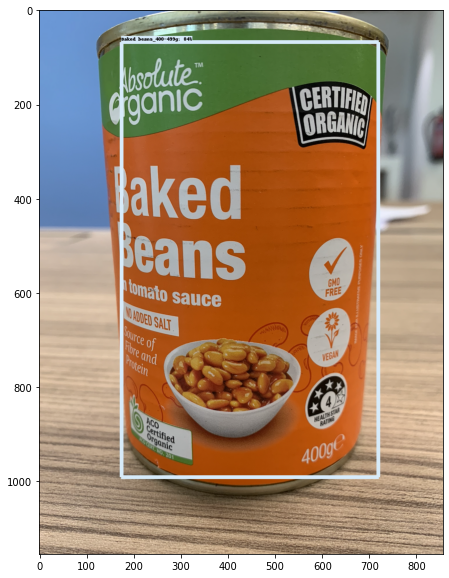

In [27]:
import cv2 
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]

# Randomly select an image to be detected
# tmp_img = random.choice([file for file in os.listdir(os.path.join(paths['IMAGE_PATH'], 
#                                               'test')) if file.endswith(".JPG")])
# IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'test', tmp_img)
tmp_img = random.choice([file for file in os.listdir(os.path.join(paths['IMAGE_PATH'], 
                                              'train')) if file.endswith(".png")])
IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'train', tmp_img)


category_index = label_map_util.create_category_index_from_labelmap(training_files['LABELMAP'])

img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=2,
            min_score_thresh=.7,
            agnostic_mode=False,
            line_thickness=8)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

In [28]:
print("detected class:")
print(category_index[detections['detection_classes'][0]+label_id_offset]['name'])
print("detected probability")
print(detections['detection_scores'][0])
print("true class")
print(tmp_img)

detected class:
Baked beans_400-499g
detected probability
0.8422542
true class
Baked beans_400-499g_13.png


In [29]:
!zip -r Tensorflow.zip Tensorflow/
from google.colab import files
files.download("/content/Tensorflow.zip")

Streaming output truncated to the last 5000 lines.
  adding: Tensorflow/models/official/nlp/data/classifier_data_lib_test.py (deflated 59%)
  adding: Tensorflow/models/official/nlp/data/train_sentencepiece.py (deflated 59%)
  adding: Tensorflow/models/official/nlp/data/data_loader.py (deflated 50%)
  adding: Tensorflow/models/official/nlp/data/data_loader_factory_test.py (deflated 49%)
  adding: Tensorflow/models/official/nlp/data/dual_encoder_dataloader.py (deflated 63%)
  adding: Tensorflow/models/official/nlp/data/pretrain_dynamic_dataloader_test.py (deflated 75%)
  adding: Tensorflow/models/official/nlp/data/question_answering_dataloader_test.py (deflated 60%)
  adding: Tensorflow/models/official/nlp/data/README.md (deflated 32%)
  adding: Tensorflow/models/official/nlp/data/pretrain_dataloader.py (deflated 77%)
  adding: Tensorflow/models/official/nlp/data/question_answering_dataloader.py (deflated 62%)
  adding: Tensorflow/models/official/nlp/data/data_loader_factory.py (deflated

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [30]:
files.download("/content/Tensorflow.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>